# Identifying Pneumonia in Lung X-Rays Using Neural Networks
#### Justin Fernandez and Lauren Phipps

## Overview <a id="Overview"></a>

This project aims to create an image classifier for identifying pneumonia in lung x-rays using neural networks in order to be able to identify patients with pneumonia based on their x-ray. Pneumonia is a lung infection where the air sacs will fill with fluid, making it hard to beathe. Pneumonia is typically diagnosed through identifying white, cloudy spots on a chest x-ray. Creating an image classifier would allow doctors to feed in images of x-rays and more quickly and accurately identify patients who will need treatment for pneumonia. A model was created and training using 5,000 images of chest x-rays labeled as "normal" or as having pneumonia. A convolutional neural network was created that led to an accuracy of 90.0% and a recall score of 85.8%. Overall, the model is somewhat successful at identifying pneumonia in chest x-rays with a low rate of false negatives (classifying an x-ray as being normal when it really has pneumonia). The next steps, though, would be to continue to iterate on the model by adding in more images to train it with and hopefully continue to increase it's recall.

[1. Business Problem](#Business-Problem)

[2. Data Understanding](#Data-Understanding)

[3. Data Preparation](#Data-Preparation)

[4. EDA](#EDA)

[5. Modeling](#Modeling)

[6. Evaluation](#Evaluation)

[7. Conclusion](#Conclusion)

***

## Business Problem <a id="Business-Problem"></a>
##### [(back to top)](#Overview)

Pneuomonia is an infection in the lungs causes the air sacs to fill with fluid making it difficult to breathe, particularly for older patients, very young patients, or patients with weakened immune systems. Diagnosis comes from identifying the infection, seen as white spots, with a chest x-ray. However, it can sometimes be challenging for humans to spot these abnormalities, so neural networks can be beneficial for analyzing and classifying lung x-rays of pneumonia patients. This project aims to create a neural network that, given an image of a chest x-ray, correctly identify whether or not the patient has pneumonia. Approximately 50,000 people per year die of pneumonia in the United States alone, therefore, it is incredibly important to accurately identify patients suffering from pneumonia to get them the treatment that they need. 

***

## Data Understanding <a id="Data-Understanding"></a>
##### [(back to top)](#Overview)

The data for this project is a collection of images of chest x-rays from both healthy patients and patients with pneumonia. These were broken into three sets: a training set, a validation set, and a testing set. They were loaded in and separated into their respective data sets. 

In [1]:
# normal working notebook imports
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

# importing keras for neural net building
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models

# scores for understanding results
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# insight into how machine makes decisions
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import random


In [2]:
# Directory path
train_data_dir = 'chest_xray/chest_xray/train/'
val_data_dir = 'chest_xray/chest_xray/val/'
test_data_dir = 'chest_xray/chest_xray/test/'


# Getting the testing data and resizing the images
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(64, 64), batch_size=600)

# Getting the validation set and resizing the images
val_generator = ImageDataGenerator().flow_from_directory(
        val_data_dir, 
        target_size=(64, 64), batch_size=16)

# Getting the training set and resizing the images
train_generator = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5200)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

# Create groups for normal images and pneuomonia images within training set
normal_imgs = [fn for fn in os.listdir(f'{train_data_dir}/NORMAL') if fn.endswith('.jpeg')]
pneumonia_imgs = [fn for fn in os.listdir(f'{train_data_dir}/PNEUMONIA') if fn.endswith('.jpeg')]


Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


There are 5,216 images in the training set, 16 images in the validation set, and 624 in the testing set.

In [3]:
print('There are', len(normal_imgs), 'normal images in the training set.')
print('There are', len(pneumonia_imgs), 'pneumonia images in the training set.')

There are 1341 normal images in the training set.
There are 3875 pneumonia images in the training set.


This indicates that there is a slight class imbalance in the data set, with pneumonia x-rays as the dominant class. 

The images are stored as RBG values for each pixel in the 64x64 image, shown below.

In [4]:
train_images[0]

array([[[76., 76., 76.],
        [84., 84., 84.],
        [95., 95., 95.],
        ...,
        [67., 67., 67.],
        [53., 53., 53.],
        [44., 44., 44.]],

       [[85., 85., 85.],
        [90., 90., 90.],
        [89., 89., 89.],
        ...,
        [60., 60., 60.],
        [53., 53., 53.],
        [46., 46., 46.]],

       [[86., 86., 86.],
        [91., 91., 91.],
        [85., 85., 85.],
        ...,
        [60., 60., 60.],
        [57., 57., 57.],
        [49., 49., 49.]],

       ...,

       [[30., 30., 30.],
        [45., 45., 45.],
        [77., 77., 77.],
        ...,
        [46., 46., 46.],
        [38., 38., 38.],
        [10., 10., 10.]],

       [[30., 30., 30.],
        [51., 51., 51.],
        [79., 79., 79.],
        ...,
        [45., 45., 45.],
        [40., 40., 40.],
        [ 9.,  9.,  9.]],

       [[44., 44., 44.],
        [50., 50., 50.],
        [63., 63., 63.],
        ...,
        [47., 47., 47.],
        [40., 40., 40.],
        [27., 27., 27.]]

However, they can be visualized as an image, shown below here.

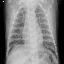

In [5]:
array_to_img(train_images[15])

The labels consist of values of either `0, 1` or `1, 0` with `0, 1` denoting that the patient has pneumonia and `1, 0` denoting that it is normal.

In [6]:
train_labels[15]

array([0., 1.], dtype=float32)

The image shown above has pneumonia.

In [7]:
print('The shape of the train images is:', np.shape(train_images))
print('The shape of the train labels is:', np.shape(train_labels))
print('The shape of the test images is:', np.shape(test_images))
print('The shape of the test labels is:', np.shape(test_labels))
print('The shape of the validation images is:', np.shape(val_images))
print('The shape of the validation labels is:', np.shape(val_labels))

The shape of the train images is: (5200, 64, 64, 3)
The shape of the train labels is: (5200, 2)
The shape of the test images is: (600, 64, 64, 3)
The shape of the test labels is: (600, 2)
The shape of the validation images is: (16, 64, 64, 3)
The shape of the validation labels is: (16, 2)


***

## Data Preparation <a id="Data-Preparation"></a>
##### [(back to top)](#Overview)

To prepare for modeling, the shape of the data set needed to change. 

In [8]:
batch_size = 10
num_classes = 2

In [9]:
# converting each image to large list of pixel values
X_train = train_images.reshape(5200,12288)
X_test = test_images.reshape(600,12288)
X_val = val_images.reshape(16,12288)

# standardizing pixel values (they range from 0-255 for how dark they are)
X_train /= 255
X_test /= 255
X_val /= 255

# changing shape from tuple to singular value
y_train_uncat = train_labels.T[[1]][0]
y_test_uncat = test_labels.T[[1]][0]
y_val_uncat = val_labels.T[[1]][0]

# converting to tuple of two values
y_train = keras.utils.to_categorical(y_train_uncat, num_classes)
y_test = keras.utils.to_categorical(y_test_uncat, num_classes)
y_val = keras.utils.to_categorical(y_val_uncat, num_classes)

pd.DataFrame(y_train)[0].value_counts()
print(X_train.shape)
print(y_train.shape)

(5200, 12288)
(5200, 2)


Next, we wanted to continue to improve the accuracy, while also addressing the class imbalance. To do this, we augmented the images by rotating some of the images and adding them into the data set. This provides the model with more information and, again, helps with overfitting as it cannot simply memorize images that look very similar. To do this, a new data set was created as shown below. 

Overfitting can be a major problem for neural nets because of how hidden layers do not give much information on what is actually being 'learned' by the hidden layers. Image augmentation is a common approach to reduce overfitting by rotating and flipping the image. This helps the neural net focus in on the actual disease rather than remeber the whole image.

In [10]:
# layer of the neural net that is used to flip and rotate images
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.5),
])

## EDA <a id="EDA"></a>
##### [(back to top)](#Overview)


The models will be trying to identify the white, cloudy spots of chest x-ray that indicate pneuomonia. An example of an x-ray from a healthy patient is below. 

***image of healthy***

Compare that with the x-ray from a pneuomonia patient below. The white spots (marked) indicate the infection. This is what the model will be looking for. 

***image of pneumonia***

In order to look deeper at the pixel data from the images, we combined all the data from the normal and pneumonia images into one matrix for each label. 

In [36]:
# making n X m matrix of all normal and pneumonia images of the training set, 
# where n = number of observations and m = the number of pixels
def img2np(path, list_of_filename, size = (64, 64)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = load_img(fp, target_size = size, 
                                       color_mode = 'grayscale')
        # covert image to a matrix
        img_ts = img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError: 
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat

#apply function to images
normal_images = img2np(f'{train_data_dir}/NORMAL/', normal_imgs)
pneumonia_images = img2np(f'{train_data_dir}/PNEUMONIA/', pneumonia_imgs)

From here, we could find the average pixel value for each label type and the standard deviation of the pixel values.

In [37]:
print('The average pixel value for normal images is ', np.mean(normal_images))
print('The average pixel value for pneumonia images is ', np.mean(pneumonia_images))
print('The standard deviation of pixels for normal images is ', np.std(normal_images))
print('The standard deviation of pixels for pneumonia images is ', np.std(pneumonia_images))

The average pixel value for normal images is  122.41054
The average pixel value for pneumonia images is  123.18151
The standard deviation of pixels for normal images is  63.017418
The standard deviation of pixels for pneumonia images is  59.72664


The means are very similar with the pneumonia images being slightly higher. This could be due to the whiter spots having a higher pixel value. Additionally, the standard deviation is higher for the normal images, which can be attributed to the overall greater contrast within the images since they do not have the white spots indicating pneumonia.

The mean images for the normal and pneumonia images are shown below. 

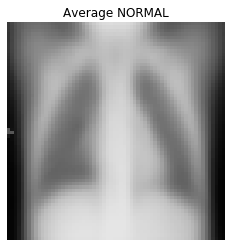

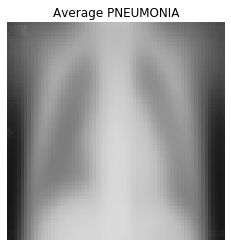

In [38]:
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pneumonia_images, 'PNEUMONIA')

These images show the variability that occurs in pneumonia x-rays throughout the lungs. Most healthy patients have lung x-rays that look similar; however, pneumonia can appear at any place within the lungs, creating the general cloudiness in the image above. This can also be seen through the standard deviation of the images below. 

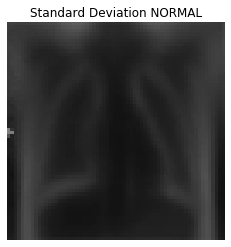

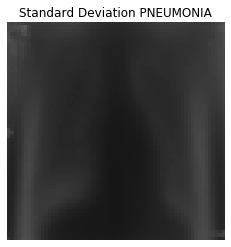

In [39]:
def find_std_img(full_mat, title, size = (64, 64)):
    # calculate the standard deviation
    std_img = np.std(full_mat, axis = 0)
    # reshape it back to a matrix
    std_img = std_img.reshape(size)
    plt.imshow(std_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Standard Deviation {title}')
    plt.axis('off')
    plt.show()
    return std_img

norm_std = find_std_img(normal_images, 'NORMAL')
pneu_std = find_std_img(pneumonia_images, 'PNEUMONIA')

Again, there is less clear distinction within the pneumonia images due to the presence of the white spots at different locations in the lungs. 

## Modeling <a id="Modeling"></a>
##### [(back to top)](#Overview)

The first step was to create a standard sequential neutral network with several dense layers. Because it is a binary classification problem, a sigmoid function was used for the output layer.



#### Vanilla Model


In [40]:
## Vanilla
# model structure
model = Sequential()

# first hidden layer
# 12288 = 64x64x3 = size of image
model.add(Dense(50,activation='relu',input_shape=(12288,)))

# second hidden layer
model.add(Dense(50,activation='relu'))


# output layer
model.add(Dense(num_classes, activation='sigmoid'))

# view the structure of the neural net
model.summary()

# creating the NN, binary_cross for classification
model.compile(loss='binary_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

# fitting the model to the train data
history = model.fit(X_train, y_train,
                   batch_size=batch_size,
                   epochs=8,
                   verbose=1,
                   validation_data=(X_val,y_val))

# how did model perform
score = model.evaluate(X_test,y_test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 50)                614450    
_________________________________________________________________
dense_19 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 102       
Total params: 617,102
Trainable params: 617,102
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
520/520 [==============================] - 1s 2ms/step - loss: 0.3099 - accuracy: 0.8706 - val_loss: 0.7585 - val_accuracy: 0.6250
Epoch 2/8
520/520 [==============================] - 1s 2ms/step - loss: 0.1841 - accuracy: 0.9302 - val_loss: 0.4373 - val_accuracy: 0.7500
Epoch 3/8
520/520 [==============================] - 1s 2ms/step - loss: 0.1900 - accuracy: 0.92

From this model we can see that normal neural nets are not very good at predicitons on images. The reason for this is that all this model can see is a long list of pixel values which dont allow it to 'see' patters or abnormalities in an image. This is where convolutional neural nets come in very useful becuase of their ability to use image filters to identify patterns in pixel by pixel areas.

The convolution layer will create colvolved features which are created by applying a function to the pixel values of an $nxn$ area (e.g. summation of all nine cells in a $3x3$ area). These allow the neural net to identify patterns in an image that are larger than a single picture that can inform a classification. 

Using pooling along with the convolutional layers reduces the dimensions of the convolved image even further. In this case we are reducing the size of input on each layer by half.

#### CNN with basic structure

In [14]:
cnn_wo_aug = tf.keras.Sequential([
    # convolution layer to find values in patterns 
    layers.Conv2D(32, (3,3), activation='relu',input_shape=(64,64,3)),
    # pooling to reduce size of vector
    layers.MaxPool2D((2,2),strides=2),

    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),
    
    # must flatten for use in dense layers
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    Dropout(0.25),
    layers.Dense(32, activation='relu'),
    Dropout(0.25),
    layers.Dense(2, activation='sigmoid')
    ])

In [13]:
cnn_w_aug = tf.keras.Sequential([
    data_augmentation,
    # convolution layer to find values in patterns 
    layers.Conv2D(32, (3,3), activation='relu',input_shape=(64,64,3)),
    # pooling to reduce size of vector
    layers.MaxPool2D((2,2),strides=2),

    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),

    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),
    
    # must flatten for use in dense layers
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    Dropout(0.25),
    layers.Dense(32, activation='relu'),
    Dropout(0.25),
    layers.Dense(2, activation='sigmoid')
    ])

In [15]:
cnn_w_aug.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history_w_aug = cnn_w_aug.fit(train_images, y_train, epochs=10,validation_data=(val_images,y_val))

score_w_aug = cnn_w_aug.evaluate(test_images,y_test,verbose=0)
print('Test loss:', score_w_aug[0])
print('Test accuracy:', score_w_aug[1])

Epoch 1/10
163/163 [==============================] - 11s 69ms/step - loss: 0.5771 - accuracy: 0.7429 - val_loss: 0.6891 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 11s 65ms/step - loss: 0.4172 - accuracy: 0.7992 - val_loss: 0.5588 - val_accuracy: 0.9375
Epoch 3/10
163/163 [==============================] - 10s 63ms/step - loss: 0.3143 - accuracy: 0.8642 - val_loss: 0.5431 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 10s 64ms/step - loss: 0.2752 - accuracy: 0.8794 - val_loss: 0.4974 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 10s 63ms/step - loss: 0.2618 - accuracy: 0.8938 - val_loss: 1.3733 - val_accuracy: 0.5625
Epoch 6/10
163/163 [==============================] - 10s 63ms/step - loss: 0.2463 - accuracy: 0.9027 - val_loss: 0.8053 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 10s 63ms/step - loss: 0.2369 - accuracy: 0.9040 - val_loss: 0.6219 - val_accuracy:

In [17]:
cnn_wo_aug.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history_wo_aug = cnn_wo_aug.fit(train_images, y_train, epochs=10,validation_data=(val_images,y_val))

score_wo_aug = cnn_wo_aug.evaluate(test_images,y_test,verbose=0)
print('Test loss:', score_wo_aug[0])
print('Test accuracy:', score_wo_aug[1])

Epoch 1/10
163/163 [==============================] - 10s 61ms/step - loss: 0.4936 - accuracy: 0.7746 - val_loss: 0.6611 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 10s 59ms/step - loss: 0.2668 - accuracy: 0.8969 - val_loss: 0.7243 - val_accuracy: 0.6875
Epoch 3/10
163/163 [==============================] - 10s 61ms/step - loss: 0.1708 - accuracy: 0.9379 - val_loss: 0.5976 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 10s 62ms/step - loss: 0.1452 - accuracy: 0.9498 - val_loss: 0.3424 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 11s 65ms/step - loss: 0.1150 - accuracy: 0.9592 - val_loss: 0.9282 - val_accuracy: 0.6875
Epoch 6/10
163/163 [==============================] - 10s 63ms/step - loss: 0.1017 - accuracy: 0.9627 - val_loss: 0.2976 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 10s 59ms/step - loss: 0.0903 - accuracy: 0.9683 - val_loss: 0.5042 - val_accuracy:

In [22]:
print("Accuracy with out augmentation: {}".format(score_wo_aug[1]))
print("Accuracy with augmentation: {}".format(score_w_aug[1]))

Accuracy with out augmentation: 0.7366666793823242
Accuracy with augmentation: 0.8600000143051147


Initially, this model's accuracy was a bit lower, so image augmentation was added to lessen the ability of the model to memorize the images because differnt orientations of the same image are seen as completely different by the model.

This increased the accuracy of predictions greatly with much lower degree of overfitting.

#### CNN with augmentation using relu for all activation functions, increased hidden layers

In [30]:
cnn_relu_aug = tf.keras.Sequential([
    data_augmentation,

    layers.Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=(64,64,3)),
    layers.MaxPool2D((2,2),strides=2),

    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),
    

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    Dropout(0.2),
    layers.Dense(64, activation='relu'),
    Dropout(0.2),
    layers.Dense(64, activation='relu'),
    Dropout(0.2),
    layers.Dense(64, activation='relu'),
    Dropout(0.2),
    layers.Dense(2, activation='sigmoid')
    ])

In [31]:
cnn_relu_aug.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history_relu_aug = cnn_relu_aug.fit(train_images, y_train,
                            epochs=10)

score_relu_aug = cnn_relu_aug.evaluate(test_images,y_test,verbose=0)
print('Test loss:', score_relu_aug[0])
print('Test accuracy:', score_relu_aug[1])

Epoch 1/10
163/163 [==============================] - 10s 63ms/step - loss: 0.5584 - accuracy: 0.7375
Epoch 2/10
163/163 [==============================] - 11s 65ms/step - loss: 0.5823 - accuracy: 0.7431
Epoch 3/10
163/163 [==============================] - 10s 61ms/step - loss: 0.5101 - accuracy: 0.7342
Epoch 4/10
163/163 [==============================] - 10s 60ms/step - loss: 0.3753 - accuracy: 0.8102
Epoch 5/10
163/163 [==============================] - 10s 61ms/step - loss: 0.3250 - accuracy: 0.8558
Epoch 6/10
163/163 [==============================] - 10s 60ms/step - loss: 0.2945 - accuracy: 0.8681
Epoch 7/10
163/163 [==============================] - 10s 62ms/step - loss: 0.2742 - accuracy: 0.8810
Epoch 8/10
163/163 [==============================] - 10s 61ms/step - loss: 0.2591 - accuracy: 0.8875
Epoch 9/10
163/163 [==============================] - 10s 60ms/step - loss: 0.2670 - accuracy: 0.8898
Epoch 10/10
163/163 [==============================] - 10s 60ms/step - loss: 0.224

This model with more layers performed slightly better than the last. This makes sense as the model was allowed more hidden layers to 'learn' more about the images. Going to try a different activation function to test whether relu is the best for this case.

#### CNN using relu as the activation function for convolution and tanh for dense layers.

In [28]:
model_cnn_aug = tf.keras.Sequential([
    data_augmentation,

    layers.Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=(64,64,3)),
    layers.MaxPool2D((2,2),strides=2),

    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPool2D((2,2),strides=2),
    

    layers.Flatten(),
    layers.Dense(64, activation='tanh'),
    Dropout(0.2),
    layers.Dense(64, activation='tanh'),
    Dropout(0.2),
    layers.Dense(64, activation='tanh'),
    Dropout(0.2),
    layers.Dense(64, activation='tanh'),
    Dropout(0.2),
    layers.Dense(2, activation='sigmoid')
    ])

In [29]:
model_cnn_aug.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

history = model_cnn_aug.fit(train_images, y_train,
                            epochs=15)

score = model_cnn_aug.evaluate(test_images,y_test,verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/15
163/163 [==============================] - 10s 60ms/step - loss: 0.5830 - accuracy: 0.7413
Epoch 2/15
163/163 [==============================] - 10s 59ms/step - loss: 0.4951 - accuracy: 0.7748
Epoch 3/15
163/163 [==============================] - 9s 58ms/step - loss: 0.3051 - accuracy: 0.8710
Epoch 4/15
163/163 [==============================] - 10s 60ms/step - loss: 0.2598 - accuracy: 0.8869
Epoch 5/15
163/163 [==============================] - 9s 58ms/step - loss: 0.2367 - accuracy: 0.9025
Epoch 6/15
163/163 [==============================] - 9s 57ms/step - loss: 0.2220 - accuracy: 0.9110
Epoch 7/15
163/163 [==============================] - 10s 63ms/step - loss: 0.2130 - accuracy: 0.9154
Epoch 8/15
163/163 [==============================] - 10s 59ms/step - loss: 0.2314 - accuracy: 0.9087
Epoch 9/15
163/163 [==============================] - 10s 59ms/step - loss: 0.1870 - accuracy: 0.9254
Epoch 10/15
163/163 [==============================] - 9s 57ms/step - loss: 0.1814 - 

The overfitting was reduced gradually due to removing hidden layers but still keeping enough to learn the target. The epoch number was originally 30 but reduced to 15 as overfitting was greatly increase with increasing epochs. This model perfomed slightly worse than the previous one using relu so that will be the final model.

## Evaluation <a id="Evaluation"></a>
##### [(back to top)](#Overview)

For this project, we focused on the recall and accuracy score. With identifying pneumonia, it is more important to minimize false negatives, as it is worse to say someone does not have pneumonia when they do and have them not receive treatment. In order to ensure we were minimized false negatives, we used recall. We also used accuracy as the measure between sets to determine if models were overfit or underfit.

#### ROC Curve

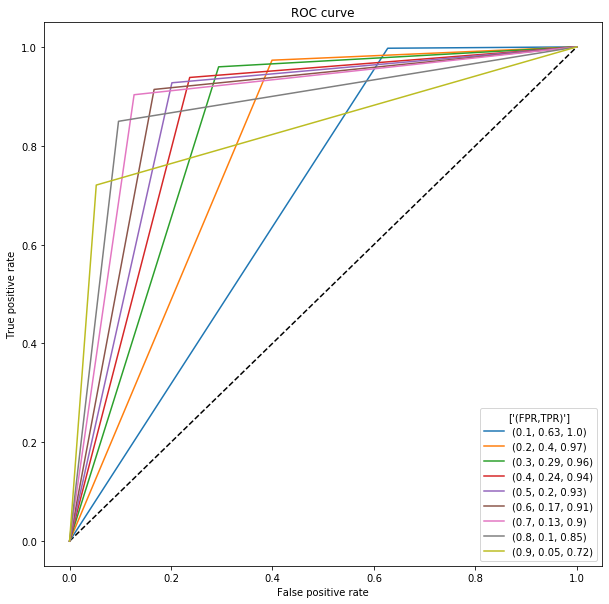

In [32]:
# differnt thresholds for predicting target
threshs = np.arange(0.1,1,0.1)

# going through each threshold to determine flase and true positive rate
y_test_roc = y_test.T[[1]][0]
def roc_per_thresh(threshs):
    rocs = []
    for thresh in threshs:
        # predicting and getting false positive and false negative rates
        # as the threshold for predicting true is increased
        y_pred_roc = (cnn_relu_aug.predict(test_images) > thresh).astype('int32')
        y_pred_roc = y_pred_roc.T[[1]][0]
        fpr, tpr, thresholds = roc_curve(y_test_roc, y_pred_roc)
        rocs.append([thresh,fpr,tpr])
    return rocs

roc_values = roc_per_thresh(threshs)

plt.figure(1,figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
for roc in roc_values:
    plt.plot(roc[1],roc[2],label=(round(roc[0],1),round(roc[1][1],2),round(roc[2][1],2)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(title=['(FPR,TPR)'])
plt.show()

#### Metrics (recall, f1, accuracy)

In [69]:
y_predicted = (model_cnn_aug.predict(test_images) > 0.7).astype("int32")
y_test_met = y_test.T[[1]][0]
y_predicted = y_predicted.T[[1]][0]
fpr, tpr, thresholds = roc_curve(y_test_met, y_predicted)

#### Confusion Matrix

In [70]:
y_test_cm = test_labels.T[[1]][0]
conf_matrix = confusion_matrix(y_test_cm,y_predicted)
df_cm = pd.DataFrame(conf_matrix,columns=['Norm','Pneu'],index=['Norm','Pneu'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

(0, 2)

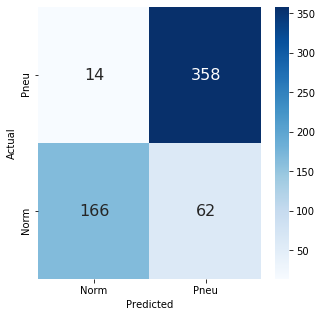

In [71]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(df_cm,cmap='Blues',annot=True,annot_kws={'size':16},fmt='g');
ax.set_ylim([0,2])


#### Metrics

In [72]:
conf_matrix = confusion_matrix(y_test_cm,y_predicted)
tpr = conf_matrix[0][0]
fpr = conf_matrix[0][1]
tnr = conf_matrix[1][1]
fnr = conf_matrix[1][0]
print('Accuracy: {}'.format((tpr+tnr)/(tpr+fpr+tnr+fnr)))
print('Recall: {}'.format(tpr/(tpr+fnr)))
print('Precision: {}'.format(tpr/(tpr+fpr)))
#print('F1: {}'.format(tpr/(tpr+fnr)))


Accuracy: 0.8733333333333333
Recall: 0.9222222222222223
Precision: 0.7280701754385965


#### Lime
Lime is a package that can be used to gain insight as to what is happening in a machine learning model. It is described as a 'prediction explainer' in that it gives insight into how black box machine models make predictions. This will help identify what the model sees that made it predict one way or another.

In [131]:
number_to_label= {
    0:['Normal'],
    1:['Pneumonia']
}
# Looking at first 3 image predictions
print("Image 1 actual: {}, predicted: {}".format(str(number_to_label[test_labels[0].T[[1]][0]]),number_to_label[y_predicted[0]]))
print("Image 1 actual: {}, predicted: {}".format(str(number_to_label[test_labels[1].T[[1]][0]]),number_to_label[y_predicted[1]]))
print("Image 1 actual: {}, predicted: {}".format(str(number_to_label[test_labels[2].T[[1]][0]]),number_to_label[y_predicted[2]]))

Image 1 actual: ['Pneumonia'], predicted: ['Pneumonia']
Image 1 actual: ['Normal'], predicted: ['Normal']
Image 1 actual: ['Normal'], predicted: ['Pneumonia']


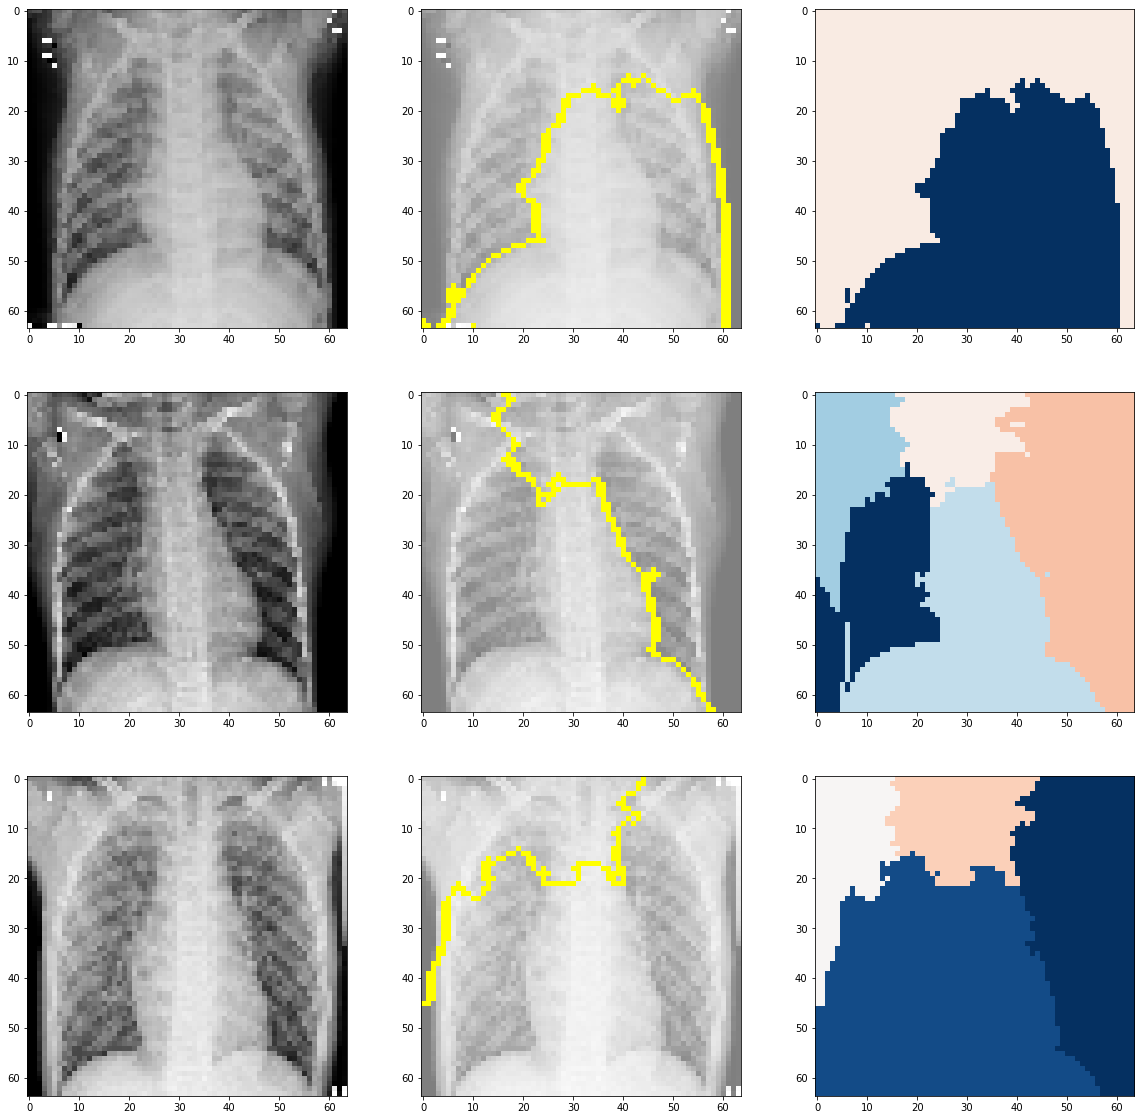

In [132]:
explainer = lime_image.LimeImageExplainer(random_state=10)
fig, ax = plt.subplots(3,3,figsize=(20,20),squeeze=True)
row_counter = 0
for image in test_images[0:3]:
    explanation = explainer.explain_instance(image.astype('double'), model_cnn_aug.predict, top_labels=5, hide_color=0, num_samples=1000)
    ax[row_counter,0].imshow(image)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    ax[row_counter,1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    ax[row_counter,2].imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    row_counter+=1

As you can see the first and second were correct predictions. In the first we can see that the large blue area was determined to support the label of pneumonia. In the second we can see that it used the right side of the chest to determine it was not pneumonia. The third got information it was not pneumonia from the top left not really grabing the area it should have.

## Conclusion <a id="Conclusion"></a>
##### [(back to top)](#Overview)

Overall, the model will successfully identify lung x-rays with pneuomonia, which can be used to determine which patients need treatment. However, more data can always be added to the model to continue to improve the quality of the model and ensure that no patients are incorrectly labeled as healthy when they actually need treatment. The next steps are to continue to iterate on the model and look more closely at the images that it incorrectly classifies to determine commonalities and address those issues in future models.